# Building a Handwritten Digits Classifier

In this project, we'll build models that can classify handwritten digits. Before the year 2000, institutions like the United States Post Office used handwriting recognition software to read addresses, zip codes, and more. One of their approaches, which consists of pre-processing handwritten images then feeding to a neural network model is detailed in [this paper](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.852.5499&rep=rep1&type=pdf).


## Introducing Dataset
We'll use a pre-loaded dataset in Scikit-learn library. The `load_digits()` function returns a copy of the [hand-written digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) from UCI.

In [1]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Because dataframes are a tabular representation of data, each image is represented as a row of pixel values. To visualize an image from the dataframe, we need to reshape the image back to its original dimensions (28 x 28 pixels). To visualize the image, we need to reshape these pixel values back into the 28 by 28 and plot them on a coordinate grid.

In [2]:
digits_data = load_digits()

In [3]:
digits_data.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [4]:
data = pd.DataFrame(digits_data['data'])
data.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [5]:
labels = pd.Series(digits_data['target'])

In [6]:
first_image = data.iloc[0]
np_image = first_image.values
np_image = np_image.reshape(8, 8)

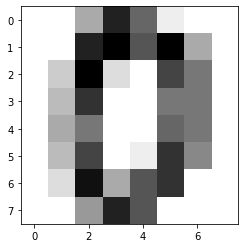

In [7]:
plt.imshow(np_image, cmap = 'gray_r')

Let's visualize some of the images in the dataset using matplotlib.

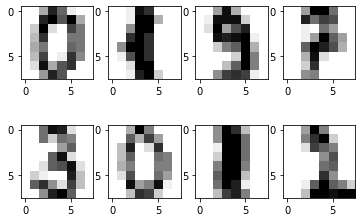

In [8]:
f, axarray = plt.subplots(2, 4)

axarray[0, 0].imshow(data.iloc[0].values.reshape(8, 8), cmap = 'gray_r')
axarray[0, 1].imshow(data.iloc[99].values.reshape(8, 8), cmap = 'gray_r')
axarray[0, 2].imshow(data.iloc[199].values.reshape(8, 8), cmap = 'gray_r')
axarray[0, 3].imshow(data.iloc[299].values.reshape(8, 8), cmap = 'gray_r')

axarray[1, 0].imshow(data.iloc[999].values.reshape(8, 8), cmap = 'gray_r')
axarray[1, 1].imshow(data.iloc[1099].values.reshape(8, 8), cmap = 'gray_r')
axarray[1, 2].imshow(data.iloc[1199].values.reshape(8, 8), cmap = 'gray_r')
axarray[1, 3].imshow(data.iloc[1299].values.reshape(8, 8), cmap = 'gray_r')

## K-Nearest Neighbors Algorithm
While linear and logistic regression models make assumptions about the linearity between the features and the output labels, the k-nearest neighbors algorithm make no such assumption. This allows them to capture nonlinearity in the data.

In [9]:
# Split up the data into train and thest sets
index = round(len(data) * 0.8)
train = data.iloc[:index].copy()
test = data.iloc[index:].copy()

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
# A function to use `KNeighborsClassifier` for training k-nearest neighbors algorithms
def train_knn(nneighbors, train_features, train_labels):
    knn = KNeighborsClassifier(n_neighbors = nneighbors)
    knn.fit(train_features, train_labels)
    return knn

# A function to test the algorithm
def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    return accuracy

# A function to perform 4-fold cross validation using train() and test()
def cross_validate(k):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state = 2, shuffle = True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train_knn(k, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

knn_one_accuracies = cross_validate(1)
np.mean(knn_one_accuracies)

0.9888728037614452

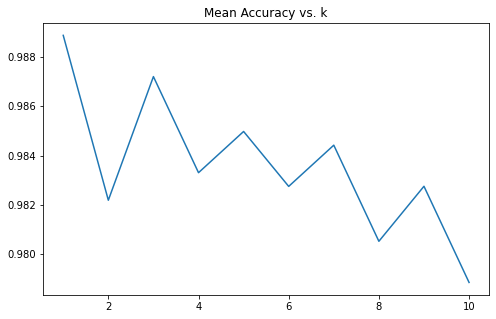

In [11]:
k_values = list(range(1,11))
k_overall_accuracies = []

for k in k_values:
    k_accuracy = cross_validate(k)
    k_mean_accuracy = np.mean(k_accuracy)
    k_overall_accuracies.append(k_mean_accuracy)
    
plt.figure(figsize = (8,5))
plt.title('Mean Accuracy vs. k')
plt.plot(k_values, k_overall_accuracies)

There are a few downsides to using k-nearest neighbors:
- high memory usage for each new unseen observation, many comparisons needed to be made to seen observations
- no model representation to debug and explore

## Neural Network with One Hidden Layer
Let's move on to a neural network with a single hidden layer.

In [12]:
from sklearn.neural_network import MLPClassifier

# A function to use `MLPClassifier` for training neural network model
def train_nn(neuron_arch, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes = neuron_arch)
    mlp.fit(train_features, train_labels)
    return mlp

# A function to test the model
def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    return accuracy

# A function to perform 4-fold cross validation using train() and test()
def cross_validate(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state = 2, shuffle = True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train_nn(neuron_arch, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

In [14]:
import warnings
warnings.filterwarnings('ignore')

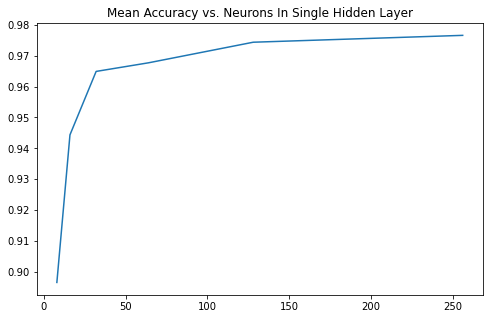

In [17]:
nn_one_neurons = [
    (8,),
    (16,),
    (32,),
    (64,),
    (128,),
    (256,)
]

nn_one_accuracies = []

for n in nn_one_neurons:
    nn_accuracy = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracy)
    nn_one_accuracies.append(nn_mean_accuracy)
    
plt.figure(figsize=(8,5))
plt.title("Mean Accuracy vs. Neurons In Single Hidden Layer")

x = [i[0] for i in nn_one_neurons]
plt.plot(x, nn_one_accuracies)

## Neural Network with Two Hidden Layers
Let's try a neural network with two hidden layers.

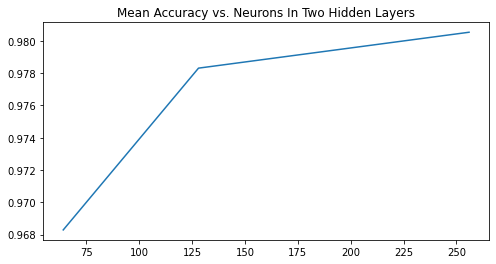

In [19]:
nn_two_neurons = [
    (64, 64),
    (128, 128),
    (256, 256)
]

nn_two_accuracies = []

for n in nn_two_neurons:
    nn_accuracy = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracy)
    nn_two_accuracies.append(nn_mean_accuracy)
    
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Two Hidden Layers")

x = [i[0] for i in nn_two_neurons]
plt.plot(x, nn_two_accuracies)

Using 2 hidden layers improved our simple accuracy to `98%`. We'd be worried about overfitting originally, but using 4-fold cross validation also gives us a bit more assurance that the model is generalizing to achieve the extra `1%` in simple accuracy over the single accuracy over the single hidden layer networks we tried earlier.



## Neural Network with Three Hidden Layers
Let's increase the number of folds we use for k-fold cross validation to 6 while testing networks with 3 hidden layers.

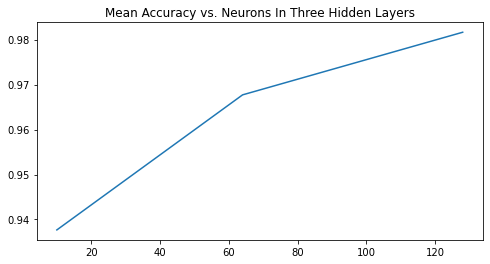

In [21]:
def cross_validate(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 6, random_state = 2, shuffle = True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train_nn(neuron_arch, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

nn_three_neurons = [
    (10, 10, 10),
    (64, 64, 64),
    (128, 128, 128)
]

nn_three_accuracies = []

for n in nn_three_neurons:
    nn_accuracy = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracy)
    nn_three_accuracies.append(nn_mean_accuracy)
    
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Three Hidden Layers")

x = [i[0] for i in nn_three_neurons]
plt.plot(x, nn_three_accuracies)

Using 3 hidden layers returned a simple accuracy of `98%`, even with 6-fold cross validation.